Taken from https://www.kaggle.com/mpware/stage1-eda-microscope-image-types-clustering

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import os
import shutil
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from textwrap import wrap
np.random.seed(1234)
%matplotlib inline

In [2]:


STAGE1_TRAIN = "data/stage1_test"
STAGE1_TRAIN_IMAGE_PATTERN = "%s/{}/images/{}.png" % STAGE1_TRAIN
#STAGE1_TRAIN_MASK_PATTERN = "%s/{}/masks/*.png" % STAGE1_TRAIN
IMAGE_ID = "image_id"
IMAGE_WIDTH = "width"
IMAGE_WEIGHT = "height"
HSV_CLUSTER = "hsv_cluster"
HSV_DOMINANT = "hsv_dominant"
#TOTAL_MASK = "total_masks"



In [3]:
def image_ids_in(root_dir, ignore=[]):
    ids = []
    for id in os.listdir(root_dir):
        if id in ignore:
            print('Skipping ID:', id)
        else:
            ids.append(id)
    return ids

In [4]:
def read_image(image_id, space="rgb"):
    image_file = STAGE1_TRAIN_IMAGE_PATTERN.format(image_id, image_id)
    image = skimage.io.imread(image_file)
    # Drop alpha which is not used
    image = image[:, :, :3]
    if space == "hsv":
        image = skimage.color.rgb2hsv(image)
    return image

In [5]:


# Get image width, height and count masks available.
def read_image_labels(image_id, space="rgb"):
    image = read_image(image_id, space = space)
    #mask_file = STAGE1_TRAIN_MASK_PATTERN.format(image_id)
    #masks = skimage.io.imread_collection(mask_file).concatenate()    
    height, width, _ = image.shape
    #num_masks = masks.shape[0]
    #labels = np.zeros((height, width), np.uint16)
    #for index in range(0, num_masks):
    #    labels[masks[index] > 0] = 255 #index + 1
    return image #, labels, num_masks



In [6]:


# Load stage 1 image identifiers.
train_image_ids = image_ids_in(STAGE1_TRAIN)



In [7]:
def get_domimant_colors(img, top_colors=2):
    img_l = img.reshape((img.shape[0] * img.shape[1], img.shape[2]))
    clt = KMeans(n_clusters = top_colors)
    clt.fit(img_l)
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    return clt.cluster_centers_, hist

In [15]:


def get_images_details(image_ids):
    details = []
    for image_id in image_ids:
        #image_hsv, labels, num_masks = read_image_labels(image_id, space="hsv")
        image_hsv = read_image_labels(image_id, space="hsv")
        height, width, l = image_hsv.shape
        dominant_colors_hsv, dominant_rates_hsv = get_domimant_colors(image_hsv, top_colors=1)
        dominant_colors_hsv = dominant_colors_hsv.reshape(1, dominant_colors_hsv.shape[0] * dominant_colors_hsv.shape[1])
        #info = (image_id, width, height, num_masks, dominant_colors_hsv.squeeze())
        info = (image_id, width, height, dominant_colors_hsv.squeeze())
        details.append(info)
    return details



In [16]:
#META_COLS = [IMAGE_ID, IMAGE_WIDTH, IMAGE_WEIGHT, TOTAL_MASK]
META_COLS = [IMAGE_ID, IMAGE_WIDTH, IMAGE_WEIGHT]
COLS = META_COLS + [HSV_DOMINANT]

In [17]:


details = get_images_details(train_image_ids)



In [18]:
trainPD = pd.DataFrame(details, columns=COLS)
X = (pd.DataFrame(trainPD[HSV_DOMINANT].values.tolist())).as_matrix()
kmeans = KMeans(n_clusters=3).fit(X)
clusters = kmeans.predict(X)
trainPD[HSV_CLUSTER] = clusters

In [19]:


trainPD.head()



,image_id,width,height,hsv_dominant,hsv_cluster
0,d616d323a9eeb9da1b66f8d5df671d63c092c9919cb2c0...,162,519,"[0.0, 0.0, 0.1952975505]",0
1,d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633f...,348,520,"[0.0, 0.0, 0.107398710147]",0
2,43a71aeb641faa18742cb826772a8566c6c947d7050f9a...,347,260,"[0.0, 0.0, 0.24174531972]",0
3,8922a6ac8fd0258ec27738ca101867169b20d90a60fc84...,640,512,"[0.0, 0.0, 0.0309152999578]",0
4,c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf...,348,524,"[0.253397026778, 0.132809937677, 0.879767981598]",1


In [20]:
def plot_images(images, images_rows, images_cols):
    f, axarr = plt.subplots(images_rows,images_cols,figsize=(16,images_rows*2))
    for row in range(images_rows):
        for col in range(images_cols):
            image_id = images[row*images_cols + col]
            image = read_image(image_id)
            height, width, l = image.shape
            ax = axarr[row,col]
            ax.axis('off')
            ax.set_title("%dx%d"%(width, height))
            ax.imshow(image)

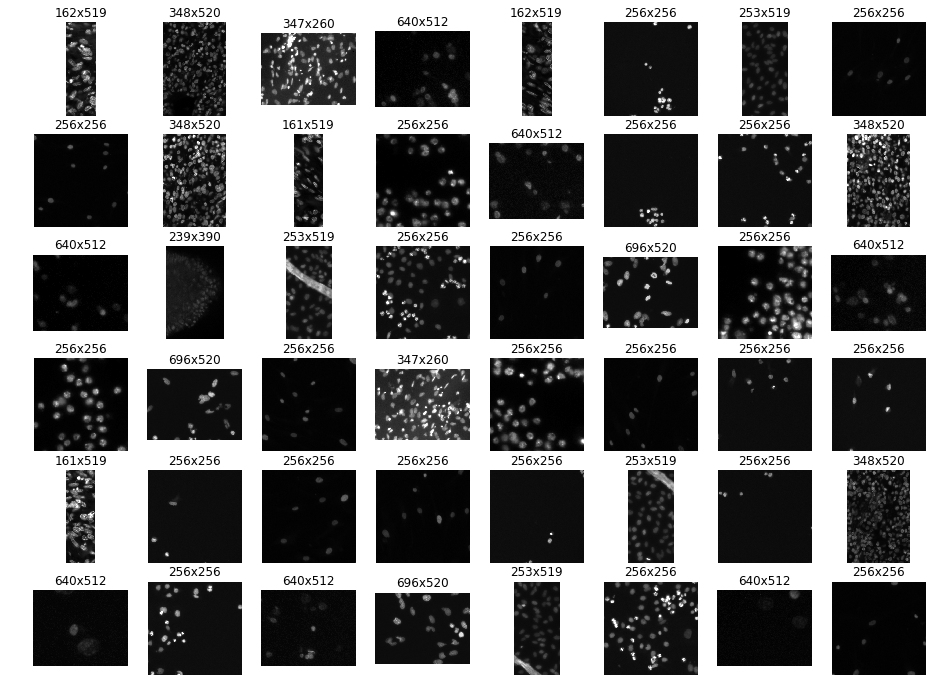

In [21]:
plot_images(trainPD[trainPD[HSV_CLUSTER] == 0][IMAGE_ID].values, 6, 8)

IndexError: index 9 is out of bounds for axis 0 with size 9

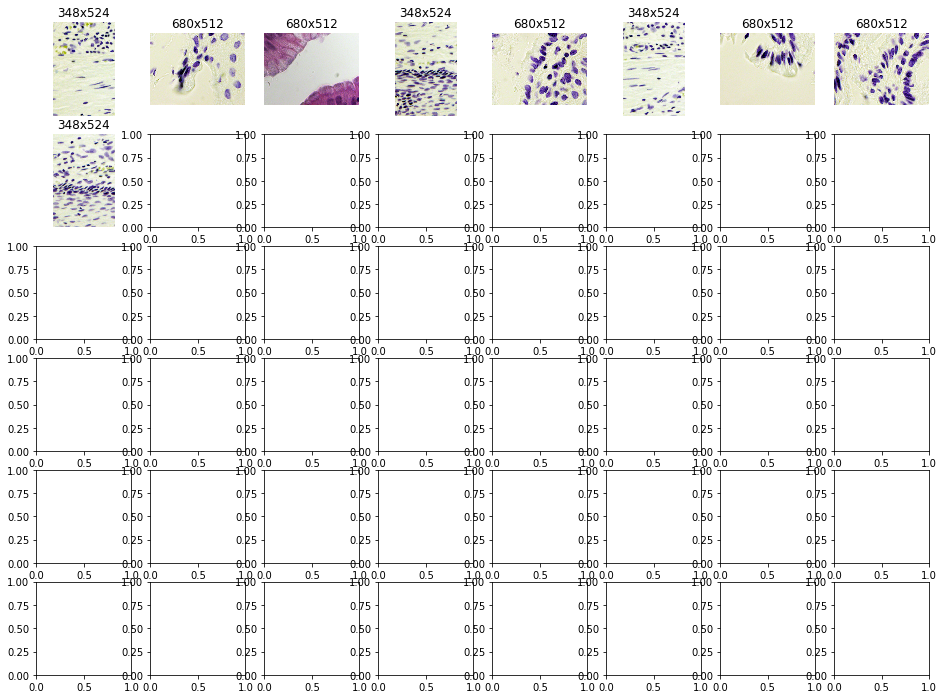

In [22]:
plot_images(trainPD[trainPD[HSV_CLUSTER] == 1][IMAGE_ID].values, 6, 8)

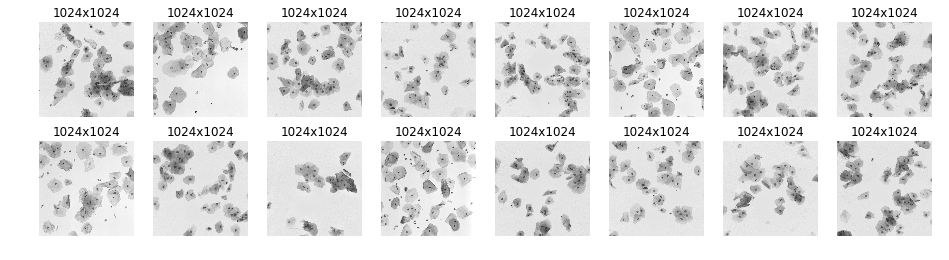

In [17]:
plot_images(trainPD[trainPD[HSV_CLUSTER] == 2][IMAGE_ID].values, 2, 8)

In [23]:


P = trainPD.groupby(HSV_CLUSTER)[IMAGE_ID].count().reset_index()
P['Percentage'] = 100*P[IMAGE_ID]/P[IMAGE_ID].sum()
P



,hsv_cluster,image_id,Percentage
0,0,53,81.538462
1,1,9,13.846154
2,2,3,4.615385


In [25]:
trainPD.to_csv('clusters_test.txt', columns=['image_id', 'hsv_cluster'])